<a href="https://colab.research.google.com/github/uditmanav17/DL-with-Python/blob/master/Chapter_6_1_Embeddings_for_Text_and_Sequences.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# DL for Text and Sequences

In [0]:
%tensorflow_version 2.x
import tensorflow as tf
import os
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import optimizers
from tensorflow.keras import losses
from tensorflow.keras import metrics
from tensorflow.keras import regularizers
from tensorflow.keras.models import load_model, Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator

This chapter explores deep-learning models that can process text (understood as
sequences of word or sequences of characters), timeseries, and sequence data in
general. The two fundamental deep-learning algorithms for sequence processing
are recurrent neural networks and 1D convnets, the one-dimensional version of the 2D convnets that we covered in the previous chapters. We’ll discuss both of these approaches in this chapter.

Applications of these algorithms include the following:
* Document classification and timeseries classification, such as identifying the
topic of an article or the author of a book
* Timeseries comparisons, such as estimating how closely related two documents or two stock tickers are
* Sequence-to-sequence learning, such as decoding an English sentence into
French
* Sentiment analysis, such as classifying the sentiment of tweets or movie reviews
as positive or negative
* Timeseries forecasting, such as predicting the future weather at a certain location, given recent weather data

This chapter’s examples focus on two narrow tasks: sentiment analysis on the IMDB dataset, a task we approached earlier in the book, and temperature forecasting. But the techniques demonstrated for these two tasks are relevant to all the applications just listed, and many more.

## 6.1 Working with text data
The deep-learning sequence-processing models introduced in the following sections can use text to produce a basic form of natural-language understanding, sufficient for applications including document classification, sentiment analysis, author identification, and even question-answering (QA) (in a constrained context). Of course, keep in mind throughout this chapter that none of these deeplearning models truly understand text in a human sense; rather, these models can map the statistical structure of written language, which is sufficient to solve many simple textual tasks. Deep learning for natural-language processing is pattern recognition applied to words, sentences, and paragraphs, in much the same way that computer vision is pattern recognition applied to pixels.

Like all other neural networks, deep-learning models don’t take as input raw text: they only work with numeric tensors. Vectorizing text is the process of transforming text into numeric tensors. This can be done in multiple ways:
* Segment text into words, and transform each word into a vector.
* Segment text into characters, and transform each character into a vector.
* Extract n-grams of words or characters, and transform each n-gram into a vector. N-grams are overlapping groups of multiple consecutive words or characters.

Collectively, the different units into which you can break down text (words, characters, or n-grams) are called tokens, and breaking text into such tokens is called tokenization. All text-vectorization processes consist of applying some tokenization scheme and then associating numeric vectors with the generated tokens. These vectors, packed into sequence tensors, are fed into deep neural networks. There are multiple ways to associate a vector with a token. In this section, I’ll present two major ones: one-hot encoding of tokens, and token embedding (typically used exclusively for words, and called
word embedding). The remainder of this section explains these techniques and shows how to use them to go from raw text to a Numpy tensor that you can send to a Keras network.

## Understanding n-grams and bag-of-words
Word n-grams are groups of N (or fewer) consecutive words that you can extract from a sentence. The same concept may also be applied to characters instead of words.
Here’s a simple example. Consider the sentence “The cat sat on the mat.” It may be decomposed into the following set of 2-grams:<br>
{"The", "The cat", "cat", "cat sat", "sat", "sat on", "on", "on the", "the", "the mat", "mat"}<br>
It may also be decomposed into the following set of 3-grams:<br>
{"The", "The cat", "cat", "cat sat", "The cat sat", "sat", "sat on", "on", "cat sat on", "on the", "the", "sat on the", "the mat", "mat", "on the mat"}<br>
Such a set is called a bag-of-2-grams or bag-of-3-grams, respectively. The term bag here refers to the fact that you’re dealing with a set of tokens rather than a list or sequence: the tokens have no specific order. This family of tokenization methods is called bag-of-words.<br>
Because bag-of-words isn’t an order-preserving tokenization method (the tokens generated are understood as a set, not a sequence, and the general structure of the sentences is lost), it tends to be used in shallow language-processing models rather than in deep-learning models. Extracting n-grams is a form of feature engineering, and deep learning does away with this kind of rigid, brittle approach, replacing it with hierarchical feature learning. One-dimensional convnets and recurrent neural networks, introduced later in this chapter, are capable of learning representations for groups of words and characters without being explicitly told about the existence of such groups,
by looking at continuous word or character sequences. For this reason, we won’t
cover n-grams any further in this book. But do keep in mind that they’re a powerful, unavoidable feature-engineering tool when using lightweight, shallow text-processing models such as logistic regression and random forests.

### 6.1.1 One-hot encoding of words and characters
One-hot encoding is the most common, most basic way to turn a token into a vector. It consists of associating a unique integer index with every word
and then turning this integer index i into a binary vector of size N (the size of the vocabulary); the vector is all zeros except for the i th entry, which is 1. One-hot encoding can be done at the character level, as well.

In [0]:
# Word-level one-hot encoding (toy example)
import numpy as np
samples = ['The cat sat on the mat.', 'The dog ate my homework.']
token_index = {}
for sample in samples:
	for word in sample.split():
		if word not in token_index:
			token_index[word] = len(token_index) + 1
max_length = 10
results = np.zeros(shape=(len(samples),max_length,max(token_index.values()) + 1))
for i, sample in enumerate(samples):
	for j, word in list(enumerate(sample.split()))[:max_length]:
		index = token_index.get(word)
		results[i, j, index] = 1.
print(results, results.shape)

[[[0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]

 [[0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]] (2, 10, 11)


In [0]:
# Character-level one-hot encoding (toy example)
import string
samples = ['The cat sat on the mat.', 'The dog ate my homework.']
characters = string.printable
token_index = dict(zip(range(1, len(characters) + 1), characters))
max_length = 50
results = np.zeros((len(samples), max_length, max(token_index.keys()) + 1))
for i, sample in enumerate(samples):
	for j, character in enumerate(sample):
		index = token_index.get(character)
		results[i, j, index] = 1.
print(results)

[[[1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 [[1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]]


Note that Keras has built-in utilities for doing one-hot encoding of text at the word level or character level, starting from raw text data. You should use these utilities, because they take care of a number of important features such as stripping special characters from strings and only taking into account the N most common words in your dataset (a common restriction, to avoid dealing with very large input vector spaces).

In [0]:
# Using Keras for word-level one-hot encoding
from tensorflow.keras.preprocessing.text import Tokenizer
samples = ['The cat sat on the mat.', 'The dog ate my homework.']
tokenizer = Tokenizer(num_words=1000)
tokenizer.fit_on_texts(samples)
sequences = tokenizer.texts_to_sequences(samples)
one_hot_results = tokenizer.texts_to_matrix(samples, mode='binary')
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 9 unique tokens.


A variant of one-hot encoding is the so-called one-hot hashing trick, which you can use when the number of unique tokens in your vocabulary is too large to handle explicitly. Instead of explicitly assigning an index to each word and keeping a reference of these indices in a dictionary, you can hash words into vectors of fixed size. This is typically done with a very lightweight hashing function. The main advantage of this method is that it does away with maintaining an explicit word index, which saves memory and allows online encoding of the data (you can generate token vectors right away, before
you’ve seen all of the available data). The one drawback of this approach is that it’s susceptible to hash collisions: two different words may end up with the same hash, and subsequently any machine-learning model looking at these hashes won’t be able to tell the difference between these words. The likelihood of hash collisions decreases when the dimensionality of the hashing space is much larger than the total number of unique tokens being hashed.

In [0]:
# Word-level one-hot encoding with hashing trick (toy example)
samples = ['The cat sat on the mat.', 'The dog ate my homework.']
dimensionality = 1000
max_length = 10
results = np.zeros((len(samples), max_length, dimensionality))
for i, sample in enumerate(samples):
    for j, word in list(enumerate(sample.split()))[:max_length]:
        index = abs(hash(word)) % dimensionality
        results[i, j, index] = 1.
print(results)

[[[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]]


### 6.1.2 Using word embeddings
Another popular and powerful way to associate a vector with a word is the use of dense ***word vectors***, also called ***word embeddings***. Whereas the vectors obtained through one-hot encoding are binary, sparse (mostly made of zeros), and very high-dimensional (same dimensionality as the number of words in the vocabulary), word embeddings are lowdimensional floating-point vectors (that is, dense vectors, as opposed to sparse vectors); see figure 6.2. Unlike the word vectors obtained via one-hot encoding, word embeddings are learned from data. It’s common to see word embeddings that are 256-dimensional, 512-dimensional, or 1,024-dimensional when dealing with very large
vocabularies. On the other hand, one-hot encoding words generally leads to vectors that are 20,000-dimensional or greater (capturing a vocabulary of 20,000 tokens, in this case). So, word embeddings pack more information into far fewer dimensions.

There are two ways to obtain word embeddings:
* Learn word embeddings jointly with the main task you care about (such as document classification or sentiment prediction). In this setup, you start with random word vectors and then learn word vectors in the same way you learn the
weights of a neural network.
* Load into your model word embeddings that were precomputed using a different machine-learning task than the one you’re trying to solve. These are called
pretrained word embeddings.



#### LEARNING WORD EMBEDDINGS WITH THE EMBEDDING LAYER
The simplest way to associate a dense vector with a word is to choose the vector at random. The problem with this approach is that the resulting embedding space has no structure: for instance, the words accurate and exact may end up with completely different embeddings, even though they’re interchangeable in most sentences. It’s difficult for a deep neural network to make sense of such a noisy, unstructured embedding space.

To get a bit more abstract, the geometric relationships between word vectors
should reflect the semantic relationships between these words. Word embeddings are meant to map human language into a geometric space. For instance, in a reasonable embedding space, you would expect synonyms to be embedded into similar word vectors; and in general, you would expect the geometric distance (such as L2 distance) between any two word vectors to relate to the semantic distance between the associated words (words meaning different things are embedded at points far away from each other, whereas related words are closer). In addition to distance, you may want specific directions in the embedding space to be meaningful. 

In real-world word-embedding spaces, common examples of meaningful geometric transformations are “gender” vectors and “plural” vectors. For instance, by adding a “female” vector to the vector “king,” we obtain the vector “queen.” By adding a “plural” vector, we obtain “kings.” Word-embedding spaces typically feature thousands of such interpretable and potentially useful vectors.

Is there some ideal word-embedding space that would perfectly map human language and could be used for any natural-language-processing task? Possibly, but we have yet to compute anything of the sort. Also, there is no such a thing as human language—there are many different languages, and they aren’t isomorphic, because a language is the reflection of a specific culture and a specific context. But more pragmatically, what makes a good word-embedding space depends heavily on your task: the perfect word-embedding space for an English-language movie-review sentimentanalysis model may look different from the perfect embedding space for an Englishlanguage legal-document-classification model, because the importance of certain semantic relationships varies from task to task.

It’s thus reasonable to learn a new embedding space with every new task. Fortunately, backpropagation makes this easy, and Keras makes it even easier. It’s about learning the weights of a layer: the Embedding layer.

In [0]:
# Instantiating an Embedding layer
from tensorflow.keras.layers import Embedding
embedding_layer = Embedding(1000, 64)
# The Embedding layer takes at least two arguments: the number of possible tokens
# (here, 1,000: 1 + maximum word index) and the dimensionality of the embeddings
# (here, 64)

The Embedding layer is best understood as a dictionary that maps integer indices
(which stand for specific words) to dense vectors. It takes integers as input, it looks up these integers in an internal dictionary, and it returns the associated vectors. It’s effectively a dictionary lookup.

When you instantiate an Embedding layer, its weights (its internal dictionary of
token vectors) are initially random, just as with any other layer. During training, these word vectors are gradually adjusted via backpropagation, structuring the space into something the downstream model can exploit. Once fully trained, the embedding space will show a lot of structure—a kind of structure specialized for the specific problem for which you’re training your model.

Let’s apply this idea to the IMDB movie-review sentiment-prediction task that
you’re already familiar with. First, you’ll quickly prepare the data. You’ll restrict the movie reviews to the top 10,000 most common words (as you did the first time you worked with this dataset) and cut off the reviews after only 20 words. The network will learn 8-dimensional embeddings for each of the 10,000 words, turn the input integer sequences (2D integer tensor) into embedded sequences (3D float tensor), flatten the tensor to 2D, and train a single Dense layer on top for classification.

In [0]:
# Loading IMDB Dataset for use with Embedding Layer
from tensorflow.keras.datasets import imdb
from tensorflow.keras import preprocessing
max_features = 10000  # No. of words to consider as feature
maxlen = 20  # Cutoff text after this number of words
(x_train, y_train), (x_test, y_test) = imdb.load_data(
    num_words=max_features)  # loads dataset as list of integers
    
# turns integer list to 2D integer Tensor of shape (samples, maxlen)
x_train = preprocessing.sequence.pad_sequences(x_train, maxlen=maxlen)
x_test = preprocessing.sequence.pad_sequences(x_test, maxlen=maxlen)

17465344/17464789 [==============================] - 0s 0us/step


In [0]:
print(x_train.shape)
print(x_test.shape)

(25000, 20)
(25000, 20)


In [0]:
from tensorflow.keras import preprocessing
from tensorflow.keras.layers import Flatten, Dense

model = Sequential()

# Specifies the maximum input length to the Embedding layer so you can 
# later flatten the embedded inputs. After the Embedding layer,
# the activations have shape (samples, maxlen, 8)
model.add(Embedding(10000, 8, input_length=maxlen))

# flatten 3D tensor to 2D tensorof shape (samples, maxlen*8)
model.add(Flatten())
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='rmsprop', 
              loss='binary_crossentropy', 
              metrics=['acc'])

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 20, 8)             80000     
_________________________________________________________________
flatten_1 (Flatten)          (None, 160)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 161       
Total params: 80,161
Trainable params: 80,161
Non-trainable params: 0
_________________________________________________________________


In [0]:
history = model.fit(x_train, y_train,
                    epochs=10,
                    batch_size=32,
                    validation_split=0.2)

Epoch 1/10
625/625 [==============================] - 1s 2ms/step - loss: 0.6747 - acc: 0.6128 - val_loss: 0.6358 - val_acc: 0.6896
Epoch 2/10
625/625 [==============================] - 1s 2ms/step - loss: 0.5579 - acc: 0.7524 - val_loss: 0.5371 - val_acc: 0.7286
Epoch 3/10
625/625 [==============================] - 1s 2ms/step - loss: 0.4659 - acc: 0.7911 - val_loss: 0.5061 - val_acc: 0.7438
Epoch 4/10
625/625 [==============================] - 1s 2ms/step - loss: 0.4192 - acc: 0.8124 - val_loss: 0.4978 - val_acc: 0.7506
Epoch 5/10
625/625 [==============================] - 1s 2ms/step - loss: 0.3880 - acc: 0.8306 - val_loss: 0.4957 - val_acc: 0.7538
Epoch 6/10
625/625 [==============================] - 1s 2ms/step - loss: 0.3617 - acc: 0.8442 - val_loss: 0.5000 - val_acc: 0.7558
Epoch 7/10
625/625 [==============================] - 1s 2ms/step - loss: 0.3391 - acc: 0.8564 - val_loss: 0.5050 - val_acc: 0.7566
Epoch 8/10
625/625 [==============================] - 1s 2ms/step - loss: 0.

You get to a validation accuracy of ~76%, which is pretty good considering that you’re only looking at the first 20 words in every review. But note that merely flattening the embedded sequences and training a single Dense layer on top leads to a model that treats each word in the input sequence separately, without considering inter-word relationships and sentence structure (for example, this model would likely treat both “this movie is a bomb” and “this movie is the bomb” as being negative reviews). It’s much better to add recurrent layers or 1D convolutional layers on top of the embedded sequences to learn features that take into account each sequence as a whole. That’s what we’ll focus on in the next few sections.

#### USING PRETRAINED WORD EMBEDDINGS
Sometimes, you have so little training data available that you can’t use your data alone to learn an appropriate task-specific embedding of your vocabulary. What do you do then?

Instead of learning word embeddings jointly with the problem you want to solve, you can load embedding vectors from a precomputed embedding space that you know is highly structured and exhibits useful properties—that captures generic aspects of language structure. The rationale behind using pretrained word embeddings in natural-language processing is much the same as for using pretrained convnets in image classification: you don’t have enough data available to learn truly powerful features on your own, but you expect the features that you need to be fairly generic—that is, common visual features or semantic features. In this case, it makes sense to reuse features learned on a different problem.

Such word embeddings are generally computed using word-occurrence statistics (observations about what words co-occur in sentences or documents), using a variety of techniques, some involving neural networks, others not. The idea of a dense, lowdimensional embedding space for words, computed in an unsupervised way, was initially explored by Bengio et al. in the early 2000s, but it only started to take off in research and industry applications after the release of one of the most famous and successful word-embedding schemes: the [Word2vec algorithm](https://code.google.com/archive/p/word2vec), developed by Tomas Mikolov at Google in 2013. Word2vec dimensions capture specific semantic properties, such as gender.

Let’s look at how you can get started using GloVe embeddings in a Keras model. The same method is valid for Word2vec embeddings or any other word-embedding database. You’ll also use this example to refresh the text-tokenization techniques introduced a few paragraphs ago: you’ll start from raw text and work your way up.

### 6.1.3 Putting it all together: from raw text to word embeddings
You’ll use a model similar to the one we just went over: embedding sentences in sequences of vectors, flattening them, and training a Dense layer on top. But you’ll do so using pretrained word embeddings; and instead of using the pretokenized IMDB data packaged in Keras, you’ll start from scratch by downloading the original text data.

####DOWNLOADING THE IMDB DATA AS RAW TEXT
First, head to http://mng.bz/0tIo and download the raw IMDB dataset. Uncompress it. Now, let’s collect the individual training reviews into a list of strings, one string per review. You’ll also collect the review labels (positive/negative) into a labels list.

In [0]:
# EXTRACTING DATASET FROM zip
import zipfile
file_path = r"/content/drive/My Drive/Colab Notebooks/Francois Chollet - DL with Python/Datasets/aclImdb.zip"
dest_path = r"/content/drive/My Drive/Colab Notebooks/Francois Chollet - DL with Python/Datasets/aclImdb"
zip_ref = zipfile.ZipFile(file_path, 'r')
zip_ref.extractall(dest_path)
zip_ref.close()

In [0]:
import os
imdb_dir = '/content/drive/My Drive/Colab Notebooks/Francois Chollet - DL with Python/Datasets/aclImdb/aclImdb'
train_dir = os.path.join(imdb_dir, 'train')
labels = []
texts = []
for label_type in ['neg', 'pos']:
    dir_name = os.path.join(train_dir, label_type)
    for fname in os.listdir(dir_name):
        if fname[-4:] == '.txt':
            f = open(os.path.join(dir_name, fname))
            texts.append(f.read())
            f.close()
            if label_type == 'neg':
                labels.append(0)
            else:
                labels.append(1)

In [0]:
print(labels[:5])
print(texts[:5])

[0, 0, 0, 0, 0]
["Story of a man who has unnatural feelings for a pig. Starts out with a opening scene that is a terrific example of absurd comedy. A formal orchestra audience is turned into an insane, violent mob by the crazy chantings of it's singers. Unfortunately it stays absurd the WHOLE time with no general narrative eventually making it just too off putting. Even those from the era should be turned off. The cryptic dialogue would make Shakespeare seem easy to a third grader. On a technical level it's better than you might think with some good cinematography by future great Vilmos Zsigmond. Future stars Sally Kirkland and Frederic Forrest can be seen briefly.", "Airport '77 starts as a brand new luxury 747 plane is loaded up with valuable paintings & such belonging to rich businessman Philip Stevens (James Stewart) who is flying them & a bunch of VIP's to his estate in preparation of it being opened to the public as a museum, also on board is Stevens daughter Julie (Kathleen Quin

####TOKENIZING THE DATA
Let’s vectorize the text and prepare a training and validation split, using the concepts introduced earlier in this section. Because pretrained word embeddings are meant to be particularly useful on problems where little training data is available (otherwise, task-specific embeddings are likely to outperform them), we’ll add the following twist: restricting the training data to the first 200 samples. So you’ll learn to classify movie reviews after looking at just 200 examples.

In [0]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np

maxlen = 100  # cuts off reviews after 100 words
training_samples = 200  # train on 200 samples only
validation_samples = 10000  #   Validate on 10000 samples
max_words = 10000  # consider only 10000 words

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)

word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

data = pad_sequences(sequences, maxlen=maxlen)

labels = np.asarray(labels)
print('Shape of data tensor:', data.shape)
print('Shape of label tensor:', labels.shape)

# Splits the data into a training set and a validation set, but first shuffles 
# the data, because you’re starting with data in which samples are ordered 
# (all negative first, then all positive)
indices = np.arange(data.shape[0])
np.random.shuffle(indices)
data = data[indices]
labels = labels[indices]

x_train = data[:training_samples]
y_train = labels[:training_samples]
x_val = data[training_samples: training_samples + validation_samples]
y_val = labels[training_samples: training_samples + validation_samples]

Found 88582 unique tokens.
Shape of data tensor: (25000, 100)
Shape of label tensor: (25000,)


####DOWNLOADING THE GLOVE WORD EMBEDDINGS
Go to https://nlp.stanford.edu/projects/glove, and download the precomputed embeddings from 2014 English Wikipedia. It’s an 822 MB zip file called glove.6B.zip, containing 100-dimensional embedding vectors for 400,000 words (or nonword tokens). Unzip it.


####PREPROCESSING THE EMBEDDINGS
Let’s parse the unzipped file (a .txt file) to build an index that maps words (as strings) to their vector representation (as number vectors).

In [0]:
# EXTRACTING DATASET FROM zip
import zipfile
file_path = r"/content/drive/My Drive/Colab Notebooks/Francois Chollet - DL with Python/Trained Models/glove.6B.zip"
dest_path = r"/content/drive/My Drive/Colab Notebooks/Francois Chollet - DL with Python/Trained Models/glove6B"
zip_ref = zipfile.ZipFile(file_path, 'r')
zip_ref.extractall(dest_path)
zip_ref.close()


In [0]:
glove_dir = dest_path
embeddings_index = {}
with open(os.path.join(glove_dir, 'glove.6B.100d.txt')) as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs
print('Found %s word vectors.' % len(embeddings_index))

Found 400000 word vectors.


Next, you’ll build an embedding matrix that you can load into an Embedding layer. It must be a matrix of shape (max_words, embedding_dim), where each entry i contains the embedding_dim-dimensional vector for the word of index i in the reference word index (built during tokenization). Note that index 0 isn’t supposed to stand for any word or token—it’s a placeholder.

In [0]:
# Preparing the GloVe word-embeddings matrix
embedding_dim = 100
embedding_matrix = np.zeros((max_words, embedding_dim))
for word, i in word_index.items():
    if i < max_words:
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector

#### DEFINING A MODEL
Same architecture as before.

In [0]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Flatten, Dense

model = Sequential()
model.add(Embedding(max_words, embedding_dim, input_length=maxlen))
model.add(Flatten())
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 100, 100)          1000000   
_________________________________________________________________
flatten (Flatten)            (None, 10000)             0         
_________________________________________________________________
dense (Dense)                (None, 32)                320032    
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 33        
Total params: 1,320,065
Trainable params: 1,320,065
Non-trainable params: 0
_________________________________________________________________


#### LOADING THE GLOVE EMBEDDINGS IN THE MODEL
The Embedding layer has a single weight matrix: a 2D float matrix where each entry i is the word vector meant to be associated with index i. Simple enough. Load the GloVe matrix you prepared into the Embedding layer, the first layer in the model.

In [0]:
model.layers[0].set_weights([embedding_matrix])
model.layers[0].trainable = False

Additionally, you’ll freeze the Embedding layer (set its trainable attribute to False), following the same rationale you’re already familiar with in the context of pretrained convnet features: when parts of a model are pretrained (like your Embedding layer) and parts are randomly initialized (like your classifier), the pretrained parts shouldn’t be updated during training, to avoid forgetting what they already know. The large gradient updates triggered by the randomly initialized layers would be disruptive to the already-learned features.

#### Training and Evaluating model 


In [0]:
model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['acc'])

history = model.fit(x_train, y_train,
                    epochs=10,
                    batch_size=32,

validation_data=(x_val, y_val))
model.save_weights('pre_trained_glove_model.h5')

Epoch 1/10
7/7 [==============================] - 1s 116ms/step - loss: 1.6688 - acc: 0.5350 - val_loss: 0.7219 - val_acc: 0.5001
Epoch 2/10
7/7 [==============================] - 1s 93ms/step - loss: 0.6386 - acc: 0.6350 - val_loss: 0.9514 - val_acc: 0.5003
Epoch 3/10
7/7 [==============================] - 1s 90ms/step - loss: 0.5696 - acc: 0.6700 - val_loss: 0.7042 - val_acc: 0.5489
Epoch 4/10
7/7 [==============================] - 1s 96ms/step - loss: 0.5159 - acc: 0.7200 - val_loss: 0.6806 - val_acc: 0.5709
Epoch 5/10
7/7 [==============================] - 1s 104ms/step - loss: 0.2317 - acc: 0.9700 - val_loss: 1.8488 - val_acc: 0.5000
Epoch 6/10
7/7 [==============================] - 1s 95ms/step - loss: 0.3428 - acc: 0.8200 - val_loss: 0.7078 - val_acc: 0.5751
Epoch 7/10
7/7 [==============================] - 1s 97ms/step - loss: 0.0881 - acc: 1.0000 - val_loss: 0.7542 - val_acc: 0.5692
Epoch 8/10
7/7 [==============================] - 1s 92ms/step - loss: 0.0534 - acc: 1.0000 - v

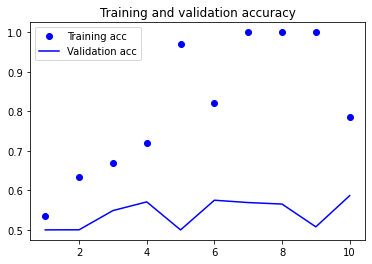

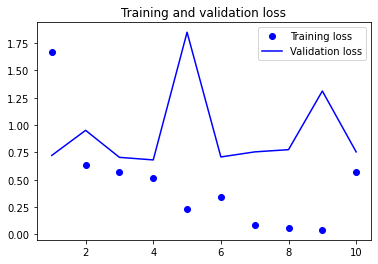

In [0]:
# Plotting the results
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

The model quickly starts overfitting, which is unsurprising given the small number of training samples. Validation accuracy has high variance for the same reason, but it seems to reach the high 50s.

Note that your mileage may vary: because you have so few training samples, performance is heavily dependent on exactly which 200 samples you choose—and you’re choosing them at random. If this works poorly for you, try choosing a different random set of 200 samples, for the sake of the exercise (in real life, you don’t get to choose your training data).

You can also train the same model without loading the pretrained word embeddings and without freezing the embedding layer. In that case, you’ll learn a taskspecific embedding of the input tokens, which is generally more powerful than pretrained word embeddings when lots of data is available. But in this case, you have only 200 training samples.

In [0]:
# Training the same model without pretrained word embeddings
from keras.models import Sequential
from keras.layers import Embedding, Flatten, Dense

model = Sequential()
model.add(Embedding(max_words, embedding_dim, input_length=maxlen))
model.add(Flatten())
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.summary()

model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['acc'])


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 100, 100)          1000000   
_________________________________________________________________
flatten_1 (Flatten)          (None, 10000)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 32)                320032    
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 33        
Total params: 1,320,065
Trainable params: 1,320,065
Non-trainable params: 0
_________________________________________________________________


Using TensorFlow backend.


In [0]:
history = model.fit(x_train, y_train,
                    epochs=10,
                    batch_size=32,
                    validation_data=(x_val, y_val))

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 200 samples, validate on 10000 samples
Epoch 1/10
200/200 [==============================] - 1s 3ms/step - loss: 0.6904 - acc: 0.5650 - val_loss: 0.6937 - val_acc: 0.5088
Epoch 2/10
200/200 [==============================] - 0s 2ms/step - loss: 0.4795 - acc: 0.9850 - val_loss: 0.6980 - val_acc: 0.5150
Epoch 3/10
200/200 [==============================] - 0s 2ms/step - loss: 0.2591 - acc: 0.9950 - val_loss: 0.7050 - val_acc: 0.5164
Epoch 4/10
200/200 [==============================] - 1s 3ms/step - loss: 0.1109 - acc: 1.0000 - val_loss: 0.7316 - val_acc: 0.5123
Epoch 5/10
200/200 [==============================] - 0s 2ms/step - loss: 0.0542 - acc: 1.0000 - val_loss: 0.7174 - val_acc: 0.5232
Epoch 6/10
200/200 [==============================] - 1s 3ms/step - loss: 0.0276 - acc: 1.0000 - val_loss: 0.7357 - val_acc: 0.5209
Epoch 7/10
200/200 [==============================] - 0s 2ms/step - loss: 0.0153 - acc: 1.0000 - val_loss: 0.7445 - val_acc: 0.5190
Epoch 8/10
200/200 [========

Validation accuracy stalls in the low 50s. So in this case, pretrained word embeddings outperform jointly learned embeddings. If you increase the number of training samples, this will quickly stop being the case—try it as an exercise. Finally, let’s evaluate the model on the test data. First, you need to tokenize the test data.

In [0]:
# Tokenizing the data of the test set
test_dir = os.path.join(imdb_dir, 'test')

labels = []
texts = []

for label_type in ['neg', 'pos']:
    dir_name = os.path.join(test_dir, label_type)
    for fname in sorted(os.listdir(dir_name)):
        if fname[-4:] == '.txt':
            f = open(os.path.join(dir_name, fname))
            texts.append(f.read())
            f.close()
            if label_type == 'neg':
                labels.append(0)
            else:
                labels.append(1)
sequences = tokenizer.texts_to_sequences(texts)
x_test = pad_sequences(sequences, maxlen=maxlen)
y_test = np.asarray(labels)

In [0]:
# Evaluationg the first model on test data
model.load_weights('pre_trained_glove_model.h5')
model.evaluate(x_test, y_test)

25000/25000 [==============================] - 1s 42us/step


[0.7669090269088745, 0.5788400173187256]

You get an appalling test accuracy of 56%. Working with just a handful of training samples is difficult!